In [1]:
# For Data Processing
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# For image manipulation
import cv2
import imutils

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from keras import layers
from keras import models

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Miscellaneous
import os
import shutil
import random
import tqdm

# Suppress future, deprecation, and SettingWithCopy warnings
import warnings
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None

# make all columns in a df viewable and wider
pd.options.display.max_columns = None
pd.options.display.width = None
pd.set_option('max_colwidth', 400)

## Data
Pituitary, no tumor, meningioma, and glioma images (7023 total, ~80/20 train test split): https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

Other tumor images (1171 T1C+ images that I will use): https://www.kaggle.com/datasets/fernando2rad/brain-tumor-mri-images-44c

In [2]:
train_dir = '/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/'
test_dir = '/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/'

# Create a new directory named "other" in the train directory
new_train_dir = os.path.join(train_dir, 'other')
if not os.path.exists(new_train_dir):
    os.makedirs(new_train_dir)

# Create a new directory named "other" in the test directory
new_test_dir = os.path.join(test_dir, 'other')
if not os.path.exists(new_test_dir):
    os.makedirs(new_test_dir)

In [3]:
supplement_labels = ['Astrocitoma T1C+', 'Carcinoma T1C+', 'Ependimoma T1C+', 'Ganglioglioma T1C+',
                'Germinoma T1C+', 'Granuloma T1C+', 'Meduloblastoma T1C+', 'Neurocitoma T1C+',
                'Oligodendroglioma T1C+', 'Papiloma T1C+', 'Schwannoma T1C+', 'Tuberculoma T1C+']

supplement_path = '/Users/eli/Desktop/brain_tumor_CNN_classifier/data/supplement/'

# Copy 80% of images to the new "other" directory in train_dir and 20% to the new "other" directory in test_dir
for label in supplement_labels:
    folder_path = os.path.join(supplement_path, label)
    files = os.listdir(folder_path)
    random.shuffle(files)
    num_files = len(files)
    num_train_files = int(num_files * 0.8)
    train_files = files[:num_train_files]
    test_files = files[num_train_files:]
    
    for filename in train_files:
        src_path = os.path.join(folder_path, filename)
        if os.path.isfile(src_path):
            dst_path = os.path.join(new_train_dir, filename)
            shutil.move(src_path, dst_path)
                
    for filename in test_files:
        src_path = os.path.join(folder_path, filename)
        if os.path.isfile(src_path):
            dst_path = os.path.join(new_test_dir, filename)
            shutil.move(src_path, dst_path)

In [4]:
labels = ['pituitary', 'notumor', 'meningioma', 'glioma', 'other']

X_train = []
y_train = []

for label in labels:
    for image in os.listdir(train_dir+label):
        X_train.append(train_dir+label+'/'+image)
        y_train.append(label)

X_train, y_train = shuffle(X_train, y_train, random_state = 1990)

In [5]:
X_test = []
y_test = []

for label in labels:
    for image in os.listdir(test_dir+label):
        X_test.append(test_dir+label+'/'+image)
        y_test.append(label)

X_test, y_test = shuffle(X_test, y_test)

In [6]:
tumor_train_df = pd.concat([pd.Series(X_train, name = 'paths'), 
                            pd.Series(y_train, name = 'label')], 
                            axis = 1)
tumor_train_df

,paths,label
0,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/pituitary/Tr-pi_1276.jpg,pituitary
1,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/other/a0287325a058f14666d4ef48d28c9e_big_gallery.jpeg,other
2,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/other/335644a887bfb5edca7415bd4f9e1e62c60fe510cd3c3802fc33c321ff053252_big_gallery.jpeg,other
3,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/other/ba6fdea01090c62f32f2711c794234_big_gallery.jpeg,other
4,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/pituitary/Tr-pi_0273.jpg,pituitary
...,...,...
6633,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/notumor/Tr-no_1577.jpg,notumor
6634,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/pituitary/Tr-pi_0633.jpg,pituitary
6635,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/glioma/Tr-gl_0206.jpg,glioma
6636,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/pituitary/Tr-pi_0795.jpg,pituitary


In [7]:
tumor_test_df = pd.concat([pd.Series(X_test, name = 'images'), 
                            pd.Series(y_test, name = 'label')], 
                            axis = 1)
tumor_test_df

,images,label
0,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/meningioma/Te-me_0082.jpg,meningioma
1,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/glioma/Te-gl_0137.jpg,glioma
2,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/other/158c06b16914d216641ccae5b41c37_big_gallery.jpeg,other
3,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/pituitary/Te-pi_0083.jpg,pituitary
4,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/notumor/Te-no_0335.jpg,notumor
...,...,...
1552,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/notumor/Te-no_0291.jpg,notumor
1553,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/glioma/Te-gl_0011.jpg,glioma
1554,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/pituitary/Te-pi_0232.jpg,pituitary
1555,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/meningioma/Te-me_0095.jpg,meningioma


## Exploratory Data Analysis

In [8]:
tumor_train_df.shape

(6638, 2)

In [9]:
tumor_train_df['label'].value_counts()

notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
other          926
Name: label, dtype: int64

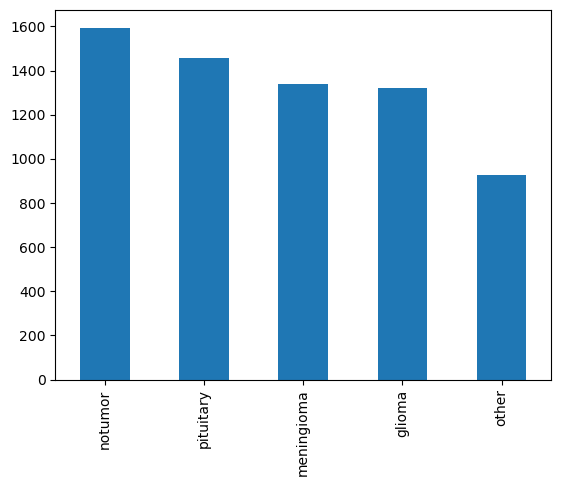

In [10]:
tumor_train_df['label'].value_counts().plot(kind = 'bar');

In [11]:
tumor_test_df['label'].value_counts()

notumor       405
meningioma    306
glioma        300
pituitary     300
other         246
Name: label, dtype: int64

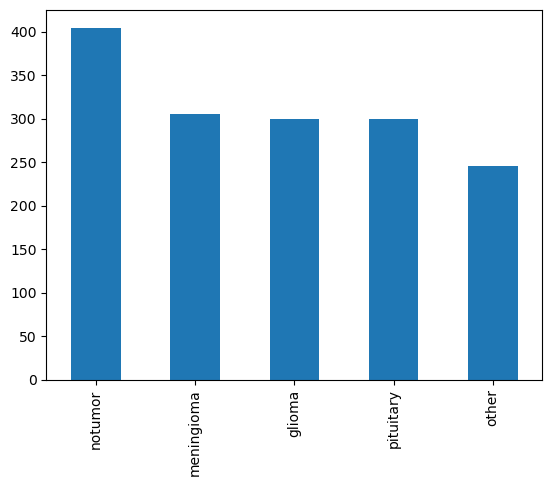

In [12]:
tumor_test_df['label'].value_counts().plot(kind = 'bar');

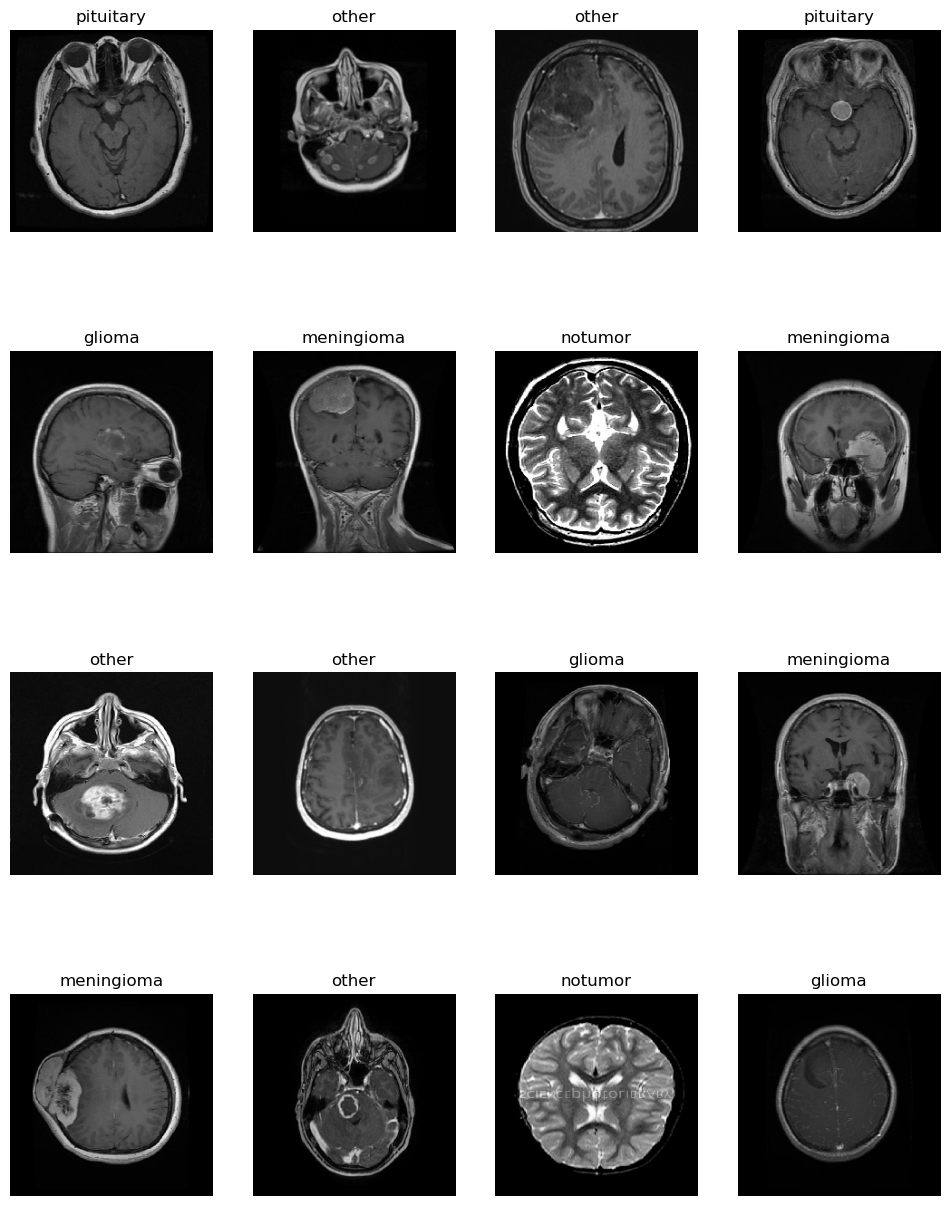

In [13]:
# with gratitude to MD Mushfirat Mohaimin for this code
# https://www.kaggle.com/code/mushfirat/brain-tumor-classification-accuracy-96

IMAGE_SIZE = (224, 224)

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays.
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=IMAGE_SIZE)
        images.append(image)
    return np.array(images, dtype=object)

images = open_images(X_train[50:67])
labels = y_train[50:67]
fig = plt.figure(figsize=(12, 16))
for x in range(1, 17):
    fig.add_subplot(4, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

## Baseline Model

In [14]:
train_datagen_baseline = ImageDataGenerator(rescale=1./255)
test_datagen_baseline = ImageDataGenerator(rescale=1./255)
batch_size = 32

train_generator_baseline = train_datagen_baseline.flow_from_directory(
        train_dir,
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale',
        seed = 1990)

test_generator_baseline = test_datagen_baseline.flow_from_directory(
        test_dir,
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale',
        seed = 1990)

Found 6636 images belonging to 5 classes.
Found 1556 images belonging to 5 classes.


In [15]:
reg = l2(3e-3)
cce = keras.losses.CategoricalCrossentropy()
opt = keras.optimizers.Adam()
callback = EarlyStopping(monitor='loss', patience=3)

model = Sequential()
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])
base_model = model.fit(train_generator_baseline,
                       verbose = 1,
                       validation_data = test_generator_baseline, 
                       epochs=30,
                       callbacks = [callback])

Metal device set to: Apple M1 Pro


2023-04-11 13:02:56.920723: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-11 13:02:56.920831: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/30


2023-04-11 13:02:57.127839: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-11 13:02:57.314987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - ETA: 0s - loss: 1.9112 - accuracy: 0.2330

2023-04-11 13:03:07.107517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - 12s 56ms/step - loss: 1.9112 - accuracy: 0.2330 - val_loss: 1.6046 - val_accuracy: 0.2603
Epoch 2/30
208/208 [==============================] - 10s 48ms/step - loss: 1.6006 - accuracy: 0.2404 - val_loss: 1.6009 - val_accuracy: 0.2603
Epoch 3/30
208/208 [==============================] - 10s 48ms/step - loss: 1.5970 - accuracy: 0.2404 - val_loss: 1.5995 - val_accuracy: 0.2603
Epoch 4/30
208/208 [==============================] - 10s 49ms/step - loss: 1.5955 - accuracy: 0.2404 - val_loss: 1.5993 - val_accuracy: 0.2603
Epoch 5/30
208/208 [==============================] - 10s 48ms/step - loss: 1.5949 - accuracy: 0.2404 - val_loss: 1.5992 - val_accuracy: 0.2603
Epoch 6/30
208/208 [==============================] - 10s 50ms/step - loss: 1.5946 - accuracy: 0.2404 - val_loss: 1.5994 - val_accuracy: 0.2603
Epoch 7/30
208/208 [==============================] - 10s 47ms/step - loss: 1.5946 - accuracy: 0.2404 - val_loss: 1.5995 - val_accuracy: 0.2603
Epo

## Data Augmentation and Second Model

In [16]:
train_datagen_aug = ImageDataGenerator(rescale=1./255,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       brightness_range=[0.75, 1.25])
test_datagen_aug = ImageDataGenerator(rescale=1./255,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      brightness_range=[0.75, 1.25])
batch_size = 32

train_generator_aug = train_datagen_aug.flow_from_directory(
        train_dir,
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale',
        seed = 1990)

test_generator_aug = test_datagen_aug.flow_from_directory(
        test_dir,
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale',
        seed = 1990)

Found 6636 images belonging to 5 classes.
Found 1556 images belonging to 5 classes.


In [21]:
model_conv = Sequential()
model_conv.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 1)))
model_conv.add(layers.MaxPooling2D((2, 2)))
model_conv.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_conv.add(layers.MaxPooling2D((2, 2)))
model_conv.add(layers.Flatten())
model_conv.add(layers.Dense(64, activation='relu'))
model_conv.add(layers.Dense(5, activation='softmax'))
model_conv.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])
conv_model = model_conv.fit(train_generator_aug,
                       verbose = 1,
                       validation_data = test_generator_aug, 
                       epochs=50)

Epoch 1/50
  1/208 [..............................] - ETA: 1:11 - loss: 1.6054 - accuracy: 0.3125

2023-04-11 13:25:14.122294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - ETA: 0s - loss: 1.2874 - accuracy: 0.4943

2023-04-11 13:25:27.508853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - 16s 75ms/step - loss: 1.2874 - accuracy: 0.4943 - val_loss: 0.9691 - val_accuracy: 0.6317
Epoch 2/50
208/208 [==============================] - 16s 75ms/step - loss: 0.7991 - accuracy: 0.6912 - val_loss: 0.8556 - val_accuracy: 0.6857
Epoch 3/50
208/208 [==============================] - 16s 76ms/step - loss: 0.6932 - accuracy: 0.7295 - val_loss: 0.7960 - val_accuracy: 0.6896
Epoch 4/50
208/208 [==============================] - 17s 80ms/step - loss: 0.6200 - accuracy: 0.7566 - val_loss: 0.7322 - val_accuracy: 0.7147
Epoch 5/50
208/208 [==============================] - 18s 85ms/step - loss: 0.5817 - accuracy: 0.7694 - val_loss: 0.6819 - val_accuracy: 0.7461
Epoch 6/50
208/208 [==============================] - 16s 77ms/step - loss: 0.5293 - accuracy: 0.7996 - val_loss: 0.6136 - val_accuracy: 0.7712
Epoch 7/50
208/208 [==============================] - 16s 75ms/step - loss: 0.5001 - accuracy: 0.8064 - val_loss: 0.5791 - val_accuracy: 0.7892
Epo

In [22]:
model_conv_drop = Sequential()
model_conv_drop.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 1)))
model_conv_drop.add(BatchNormalization())
model_conv_drop.add(layers.MaxPooling2D((2, 2)))
model_conv_drop.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_conv_drop.add(layers.MaxPooling2D((2, 2)))
model_conv_drop.add(layers.Flatten())
model_conv_drop.add(layers.Dense(128, activation='relu'))
model_conv_drop.add(Dropout(0.3))
model_conv_drop.add(layers.Dense(64, activation='relu'))
model_conv_drop.add(layers.Dense(5, activation='softmax'))
model_conv_drop.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])
conv_drop_model = model_conv_drop.fit(train_generator_aug,
                       verbose = 1,
                       validation_data = test_generator_aug, 
                       epochs=50)

Epoch 1/50


2023-04-11 13:38:24.895201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - ETA: 0s - loss: 2.6842 - accuracy: 0.3983

2023-04-11 13:38:42.147031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - 20s 94ms/step - loss: 2.6842 - accuracy: 0.3983 - val_loss: 1.9008 - val_accuracy: 0.1928
Epoch 2/50
208/208 [==============================] - 20s 94ms/step - loss: 0.9963 - accuracy: 0.6207 - val_loss: 1.9217 - val_accuracy: 0.1928
Epoch 3/50
208/208 [==============================] - 20s 95ms/step - loss: 0.8377 - accuracy: 0.6775 - val_loss: 1.1512 - val_accuracy: 0.5263
Epoch 4/50
208/208 [==============================] - 20s 94ms/step - loss: 0.6742 - accuracy: 0.7364 - val_loss: 0.6591 - val_accuracy: 0.7455
Epoch 5/50
208/208 [==============================] - 21s 99ms/step - loss: 0.5855 - accuracy: 0.7741 - val_loss: 0.5127 - val_accuracy: 0.8001
Epoch 6/50
208/208 [==============================] - 21s 99ms/step - loss: 0.5003 - accuracy: 0.8052 - val_loss: 0.4581 - val_accuracy: 0.8207
Epoch 7/50
208/208 [==============================] - 20s 97ms/step - loss: 0.4163 - accuracy: 0.8362 - val_loss: 0.5407 - val_accuracy: 0.7931
Epo

## VGG

In [19]:
train_generator_vgg = train_datagen_aug.flow_from_directory(
        train_dir,
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        seed = 1990)

test_generator_vgg = test_datagen_aug.flow_from_directory(
        test_dir,
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        seed = 1990)

In [20]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

vggmodel = Sequential()
vggmodel.add(vgg)
vggmodel.add(layers.Flatten())
vggmodel.add(layers.Dense(256, activation='relu'))
vggmodel.add(Dropout(0.25))
vggmodel.add(layers.Dense(128, activation='relu'))
vggmodel.add(Dropout(0.2))
vggmodel.add(layers.Dense(64, activation='relu'))
vggmodel.add(layers.Dense(5, activation='softmax'))
vggmodel.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])

vgg_model = vggmodel.fit(train_generator_vgg,
                       verbose = 1,
                       validation_data = test_generator_vgg, 
                       epochs=30,
                       callbacks = [callback])